# Import Packages

In [2]:
# Import packages
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
logs_df = pd.read_csv("../Data Cleaning/cleaned_dataset.csv")
logs_df

,SEX,AGE,RXASP,RXHEP,FDEAD,FDENNIS,FRECOVER,RXHEP_1,TREATMENT,REWARD_BERNOULLI,REWARD_CATEGORICAL,REWARD_VALUE (BER),REWARD_VALUE (CAT)
0,M,YOUNG,N,N,N,Y,N,N,1,Alive,Alive and still dependent,1,0.301196
1,F,OLD,Y,L,N,Y,N,L,4,Alive,Alive and still dependent,1,0.301196
2,M,OLD,N,N,Y,NaN,NaN,N,1,Dead,Dead,0,0.419251
3,M,YOUNG,Y,L,N,N,Y,L,4,Alive,Alive and recovered,1,0.274168
4,M,OLD,Y,L,N,Y,N,L,4,Alive,Alive and still dependent,1,0.301196
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,M,YOUNG,N,L,N,N,N,L,2,Alive,Alive and recovered,1,0.274168
2496,F,YOUNG,N,L,N,N,Y,L,2,Alive,Alive and recovered,1,0.274168
2497,F,OLD,Y,N,N,N,Y,N,3,Alive,Alive and recovered,1,0.274168
2498,M,OLD,Y,N,Y,NaN,NaN,N,3,Dead,Dead,0,0.419251


In [4]:
# Generate a list of 2500 tuples of gender and age values
# AGE: OLD = 1, YOUNG = 0
logs_df.loc[logs_df['AGE'] == 'OLD', 'AGE_new'] = 1
logs_df.loc[logs_df['AGE'] == 'YOUNG', 'AGE_new'] = 0
logs_df["AGE_new"] = logs_df["AGE_new"].astype(int)
# GENDER: M = 1, F = 0
logs_df.loc[logs_df['SEX'] == 'M', 'SEX_new'] = 1
logs_df.loc[logs_df['SEX'] == 'F', 'SEX_new'] = 0
logs_df["SEX_new"] = logs_df["SEX_new"].astype(int)

gender_list = logs_df['SEX_new'].to_numpy()
age_list = logs_df['AGE_new'].to_numpy()

gender_age_list = list(zip(gender_list, age_list))
gender_age_list = np.array(gender_age_list)
gender_age_list


array([[1, 0],
       [0, 1],
       [1, 1],
       ...,
       [0, 1],
       [1, 1],
       [0, 1]])

# Algorithms

In [5]:
class LinUCB:
    def __init__(self, n_arms, n_features, alpha):
        self.n_arms = n_arms
        self.n_features = n_features
        self.alpha = alpha
        self.A = [np.identity(n_features) for _ in range(n_arms)]
        self.b = [np.zeros(n_features) for _ in range(n_arms)]

    def update(self, arm, x_t, reward):
        self.A[arm] += np.outer(x_t, x_t)
        self.b[arm] += reward * x_t

    def recommend(self, x_t):
        scores = np.zeros(self.n_arms)
        thetas = [np.zeros(self.n_features) for _ in range(self.n_arms)]
        for arm in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[arm])
            theta = A_inv @ self.b[arm]
            p_arm = theta.T @ x_t + self.alpha * np.sqrt(x_t.T @ A_inv @ x_t)
            scores[arm] = p_arm
            thetas[arm] = theta
        return np.argmax(scores), thetas, scores

In [6]:
class LinThompsonSampling:
    def __init__(self, n_arms, n_features, alpha):
        self.n_arms = n_arms
        self.n_features = n_features
        self.B = [np.identity(n_features) for _ in range(n_arms)] 
        self.mu_hat = [np.zeros(n_features) for _ in range(n_arms)]
        self.f = [np.zeros(n_features) for _ in range(n_arms)]
        self.alpha = alpha
        # self.v = R * np.sqrt(24 / epsilon * n_features * np.log(1 / delta))

    def update(self, arm, x_t, reward):
        self.B[arm] += x_t.dot(x_t.T)
        self.f[arm] += reward*x_t
        self.mu_hat[arm] = np.linalg.inv(self.B[arm]).dot(self.f[arm])

    def recommend(self, x_t):
        scores = np.zeros(self.n_arms)
        thetas = [np.zeros(self.n_features) for _ in range(self.n_arms)]
        for arm in range(self.n_arms):
            mu_tilde = np.random.multivariate_normal(self.mu_hat[arm].flat, self.alpha**2 * np.linalg.inv(self.B[arm]))[..., np.newaxis]
            # theta = 1/(1+np.exp(-1 * self.f[arm]))
            theta = 1/(1+np.exp(-1 * self.B[arm].dot(self.mu_hat[arm])))
            scores[arm] = x_t.dot(mu_tilde)
            thetas[arm] = theta
        return np.argmax(scores), thetas, scores

# Simulation and Tuning

In [7]:
def simulate_one_time_reward(arm, x_t, theta, scale_noise = 0.01):
    signal = theta @ x_t
    noise  = np.random.normal(scale = scale_noise) 
    return (signal + noise)

In [8]:
# Implement Simulation Test
def test_algorithm(algo, n_arms, n_features, n_sims, n_steps, alpha, gender_age_list):
    chosen_arms = [0 for i in range(n_sims * n_steps)]
    rewards = [0 for i in range(n_sims * n_steps)]
    cumulative_rewards = [0 for i in range(n_sims * n_steps)]
    sim_rounds = [0 for i in range(n_sims * n_steps)]
    time_steps = [0 for i in range(n_sims * n_steps)]
    
    for sim in range(n_sims):
        sim = sim + 1
        
        for t in range(n_steps):
            x_t = gender_age_list[t]
            t = t + 1
            index = (sim-1) * n_steps + t - 1
            sim_rounds[index] = sim
            time_steps[index] = t
            
            chosen_arm, thetas, scores = algo.recommend(x_t)
            chosen_arms[index] = chosen_arm
            
            theta = thetas[chosen_arm]
            
            reward = simulate_one_time_reward(chosen_arm, x_t, theta, scale_noise = 0.01)
            rewards[index] = reward
            
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward 
            
            algo.update(chosen_arm, x_t, reward)

    return (sim_rounds, time_steps, chosen_arms, rewards, cumulative_rewards)

## LinUCB

In [9]:
n_steps = gender_age_list.shape[0]
n_sims = 20
alpha_values = [0.1, 0.5, 1, 5, 10]
num_features = 2
num_arms = 4
all_results_linUCB = pd.DataFrame(columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"])

In [10]:
for alpha in alpha_values:
    linUCB_algo = LinUCB(num_arms, num_features, alpha)
    results_linUCB = pd.DataFrame(test_algorithm(linUCB_algo, num_arms, num_features, 
                                                  n_sims, n_steps, alpha, gender_age_list)).transpose()
    results_linUCB.columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"]
    results_linUCB["alpha"] = alpha
    all_results_linUCB = pd.concat([all_results_linUCB, results_linUCB])

In [11]:
all_results_linUCB["n_sim"] = all_results_linUCB["n_sim"].astype(int)
all_results_linUCB["n_step"] = all_results_linUCB["n_step"].astype(int)
all_results_linUCB["chosen_treatment"] = all_results_linUCB["chosen_treatment"].astype(int)
all_results_linUCB = all_results_linUCB.reset_index(drop = True)

In [12]:
all_results_linUCB

,n_sim,n_step,chosen_treatment,rewards,cumulative_rewards,alpha
0,1,1,0,0.006267,0.006267,0.1
1,1,2,0,0.003677,0.009944,0.1
2,1,3,1,0.001045,0.010989,0.1
3,1,4,2,0.002441,0.013430,0.1
4,1,5,3,-0.001091,0.012339,0.1
...,...,...,...,...,...,...
249995,20,2496,1,-0.041178,-4.400774,10.0
249996,20,2497,0,-0.009025,-4.409798,10.0
249997,20,2498,1,0.018883,-4.390916,10.0
249998,20,2499,2,-0.015149,-4.406064,10.0


In [13]:
# If chosen_treatment = to the treatment with highest click_probability, return 1 else 0
success_probabilities_linUCB = [0.6, 0.4, 0.8, 0.9]

all_results_linUCB['if_best_treatment'] = np.where(all_results_linUCB['chosen_treatment'] == success_probabilities_linUCB.index(max(success_probabilities_linUCB)), 1, 0)

# Group by epsilon and n_step
results_plot_linUCB = all_results_linUCB.groupby(['alpha', 'n_step'], as_index = False).aggregate({'if_best_treatment': lambda x: x.sum() / float(x.count()), "rewards":"mean", "cumulative_rewards":"mean"})

In [14]:
results_plot_linUCB

,alpha,n_step,if_best_treatment,rewards,cumulative_rewards
0,0.1,1,0.05,0.002201,0.002201
1,0.1,2,0.00,0.014300,0.016501
2,0.1,3,0.00,0.012263,0.028764
3,0.1,4,0.05,0.004497,0.033261
4,0.1,5,0.05,0.006907,0.040168
...,...,...,...,...,...
12495,10.0,2496,0.20,-0.009947,-6.431323
12496,10.0,2497,0.00,0.000991,-6.430331
12497,10.0,2498,0.15,0.005190,-6.425142
12498,10.0,2499,0.30,-0.008319,-6.433461


### Rewards

Text(0.5, 1.0, 'The probability of choosing the best treatment')

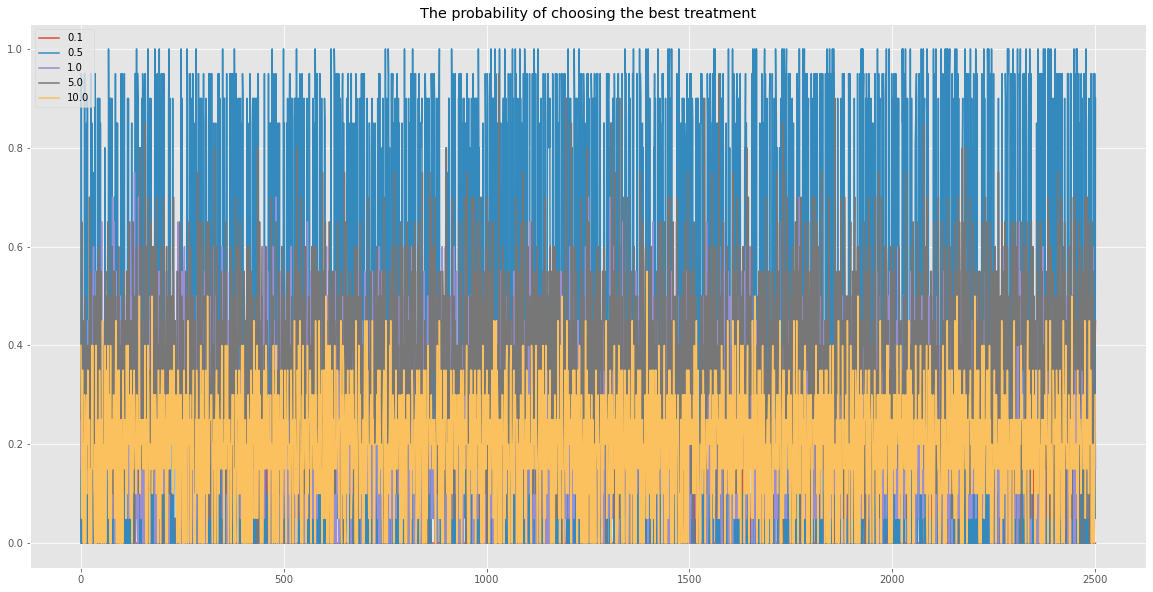

In [15]:
plt.style.use('ggplot')

# Plot the probability of choosing the best movie
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for alpha in results_plot_linUCB['alpha'].unique():
    results_linUCB = results_plot_linUCB[results_plot_linUCB['alpha'] == alpha]
    ax.plot(results_linUCB['n_step'], results_linUCB['if_best_treatment'], label = str(alpha))

plt.legend() 
plt.title("The probability of choosing the best treatment")

Text(0.5, 1.0, 'Average rewards at each time step')

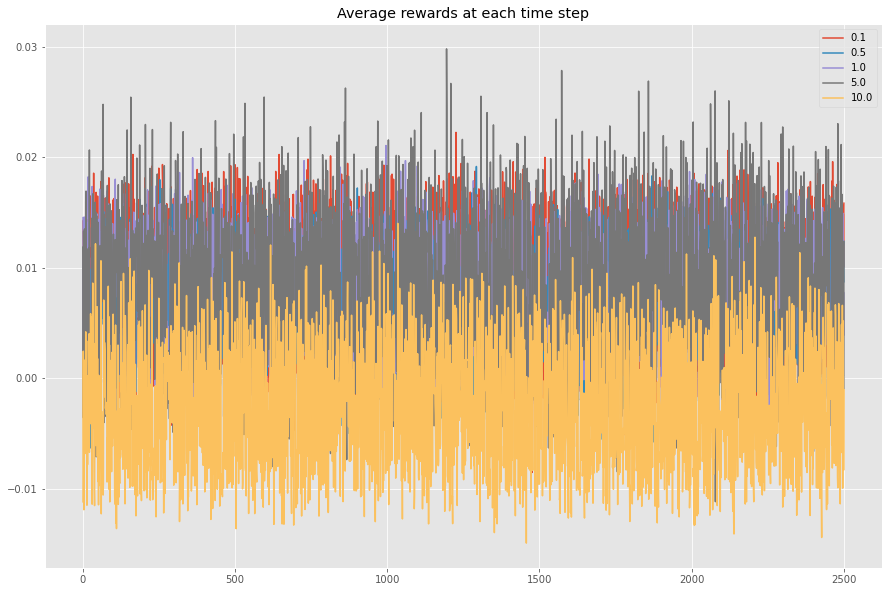

In [16]:
# plot the rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

for alpha in results_plot_linUCB['alpha'].unique():
    results_linUCB = results_plot_linUCB[results_plot_linUCB['alpha'] == alpha]
    ax.plot(results_linUCB['n_step'], results_linUCB['rewards'], label = str(alpha))

plt.legend()
plt.title("Average rewards at each time step")

In [17]:
# Determine the cumulative reward at 1000 time step
results_plot_linUCB[results_plot_linUCB["n_step"] == 2500]

,alpha,n_step,if_best_treatment,rewards,cumulative_rewards
2499,0.1,2500,0.00,0.015853,21.481995
4999,0.5,2500,0.90,0.008737,19.370754
7499,1.0,2500,0.15,0.003927,19.568858
9999,5.0,2500,0.45,-0.000923,17.147706
12499,10.0,2500,0.30,-0.001041,-6.434502


Text(0.5, 1.0, 'Cumulative rewards at each step')

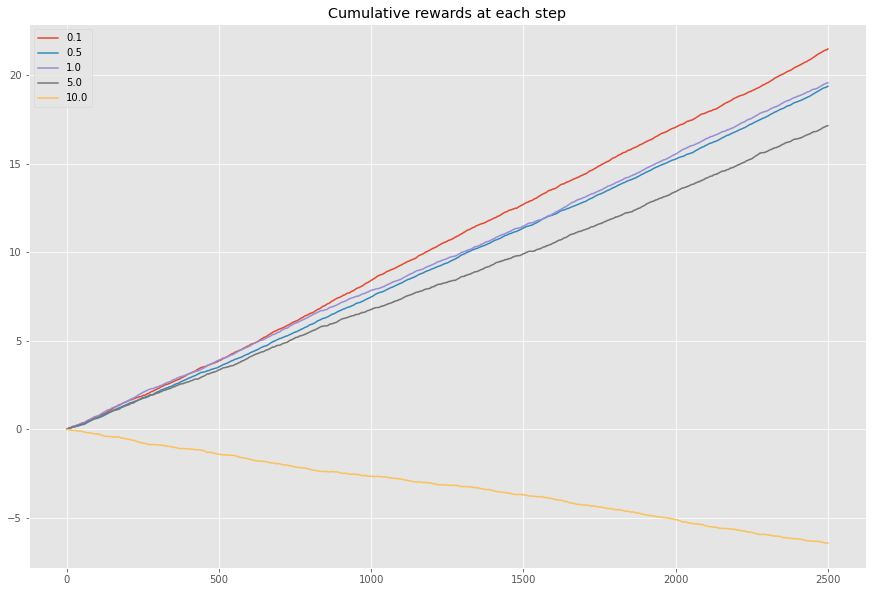

In [18]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)
    
for alpha in results_plot_linUCB['alpha'].unique():
    results_linUCB = results_plot_linUCB[results_plot_linUCB['alpha'] == alpha]
    ax.plot(results_linUCB['n_step'], results_linUCB['cumulative_rewards'], label = str(alpha))

plt.legend()
plt.title("Cumulative rewards at each step")

## Lin Thompson Sampling

In [29]:
all_results_linTS = pd.DataFrame(columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"])
R_values = [0.01, 0.1]
epsilon_values = [0.1, 0.5, 0.9]
delta = 0.5
# alpha_values = [0.1, 1, 10, 100, 1000]
alpha_values = []

for R in R_values:
    for epsilon in epsilon_values:
        alpha_value = R * np.sqrt(24 / epsilon * num_features * np.log(1 / delta))
        alpha_values.append(alpha_value)

In [30]:
for alpha in alpha_values:
    linTS_algo = LinThompsonSampling(num_arms, num_features, alpha)
    results_linTS = pd.DataFrame(test_algorithm(linTS_algo, num_arms, num_features, 
                                                n_sims, n_steps, alpha, gender_age_list)).transpose()
    results_linTS.columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"]
    results_linTS["alpha"] = alpha
    all_results_linTS = pd.concat([all_results_linTS, results_linTS])

In [31]:
all_results_linTS["n_sim"] = all_results_linTS["n_sim"].astype(int)
all_results_linTS["n_step"] = all_results_linTS["n_step"].astype(int)
all_results_linTS["chosen_treatment"] = all_results_linTS["chosen_treatment"].astype(int)
all_results_linTS = all_results_linTS.reset_index(drop = True)

In [32]:
all_results_linTS

,n_sim,n_step,chosen_treatment,rewards,cumulative_rewards,alpha
0,1,1,0,0.505259,0.505259,0.182404
1,1,2,3,0.505884,1.011142,0.182404
2,1,3,3,1.107275,2.118417,0.182404
3,1,4,0,0.620321,2.738738,0.182404
4,1,5,3,1.572920,4.311658,0.182404
...,...,...,...,...,...,...
299995,20,2496,0,0.986908,2912.386963,0.608012
299996,20,2497,0,-0.000706,2912.386257,0.608012
299997,20,2498,2,0.983104,2913.369362,0.608012
299998,20,2499,1,1.992616,2915.361977,0.608012


In [33]:
all_results_linTS['if_best_treatment'] = np.where(all_results_linTS['chosen_treatment'] == success_probabilities_linUCB.index(max(success_probabilities_linUCB)), 1, 0)

# Group by n_step
results_plot_linTS = all_results_linTS.groupby(['alpha', 'n_step'], as_index = False).aggregate({'if_best_treatment': lambda x: x.sum() / float(x.count()), "rewards":"mean", "cumulative_rewards":"mean"})

In [34]:
results_plot_linTS

,alpha,n_step,if_best_treatment,rewards,cumulative_rewards
0,0.060801,1,0.00,0.973273,0.973273
1,0.060801,2,0.00,0.970583,1.943855
2,0.060801,3,0.00,1.959633,3.903488
3,0.060801,4,0.00,0.992169,4.895657
4,0.060801,5,0.00,1.986393,6.882050
...,...,...,...,...,...
14995,1.824036,2496,0.00,1.001564,2911.455978
14996,1.824036,2497,0.00,0.002486,2911.458464
14997,1.824036,2498,0.00,1.000308,2912.458773
14998,1.824036,2499,0.65,2.000824,2914.459597


### Rewards

Text(0.5, 1.0, 'The probability of choosing the best treatment')

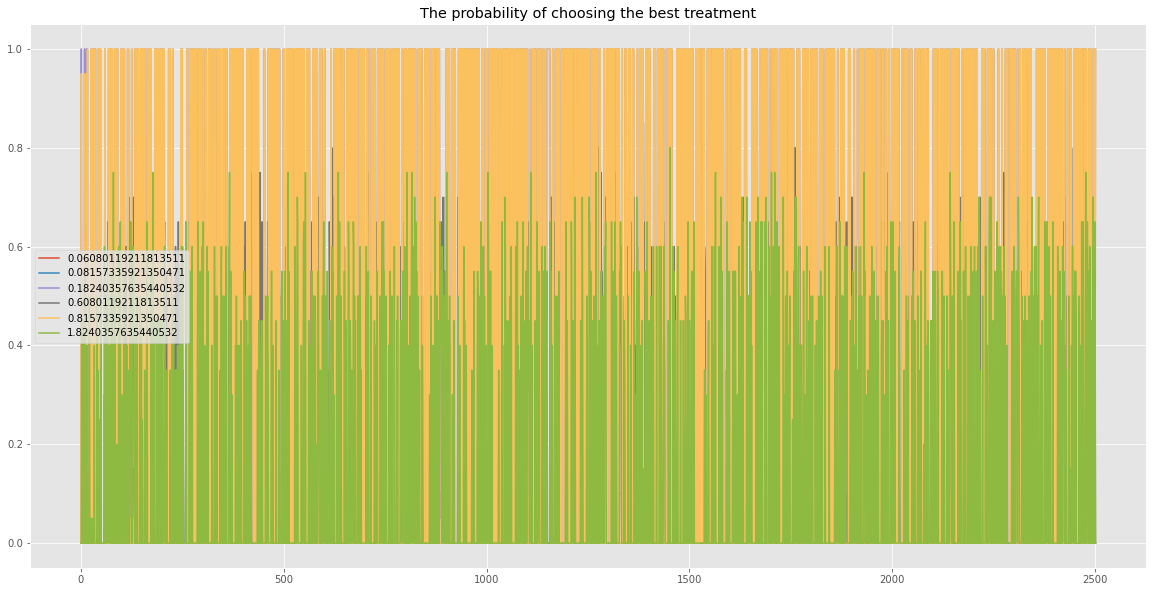

In [35]:
plt.style.use('ggplot')

# Plot the probability of choosing the best treatment
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for alpha in results_plot_linTS['alpha'].unique():
    results_linTS = results_plot_linTS[results_plot_linTS['alpha'] == alpha]
    ax.plot(results_linTS['n_step'], results_linTS['if_best_treatment'], label = str(alpha))

plt.legend() 
plt.title("The probability of choosing the best treatment")

Text(0.5, 1.0, 'Average rewards at each time step')

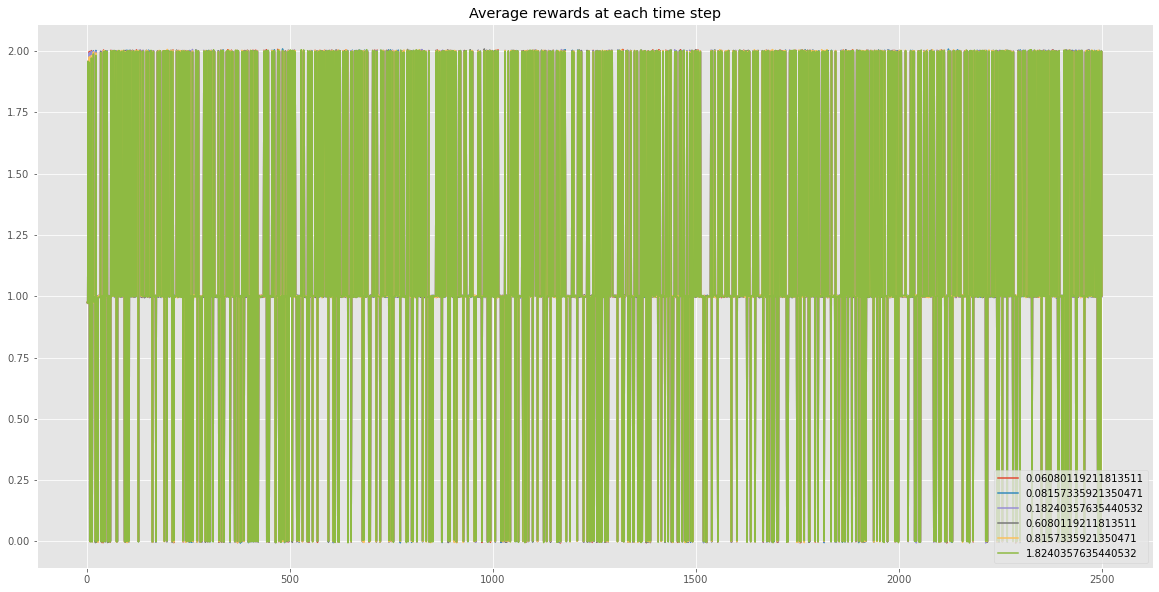

In [36]:
plt.style.use('ggplot')

# Plot the probability of choosing the best treatment
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for alpha in results_plot_linTS['alpha'].unique():
    results_linTS = results_plot_linTS[results_plot_linTS['alpha'] == alpha]
    ax.plot(results_linTS['n_step'], results_linTS['rewards'], label = str(alpha))

plt.legend() 
plt.title("Average rewards at each time step")

In [37]:
# Determine the cumulative reward at 1000 time step
results_plot_linTS[results_plot_linTS["n_step"] == 2500]

,alpha,n_step,if_best_treatment,rewards,cumulative_rewards
2499,0.060801,2500,0.0,1.000835,2915.820873
4999,0.081573,2500,0.0,1.000592,2915.703676
7499,0.182404,2500,1.0,0.997316,2915.583222
9999,0.608012,2500,0.0,1.000749,2915.560208
12499,0.815734,2500,1.0,1.001759,2915.659496
14999,1.824036,2500,0.0,1.003365,2915.462961


Text(0.5, 1.0, 'Cumulative rewards at each step')

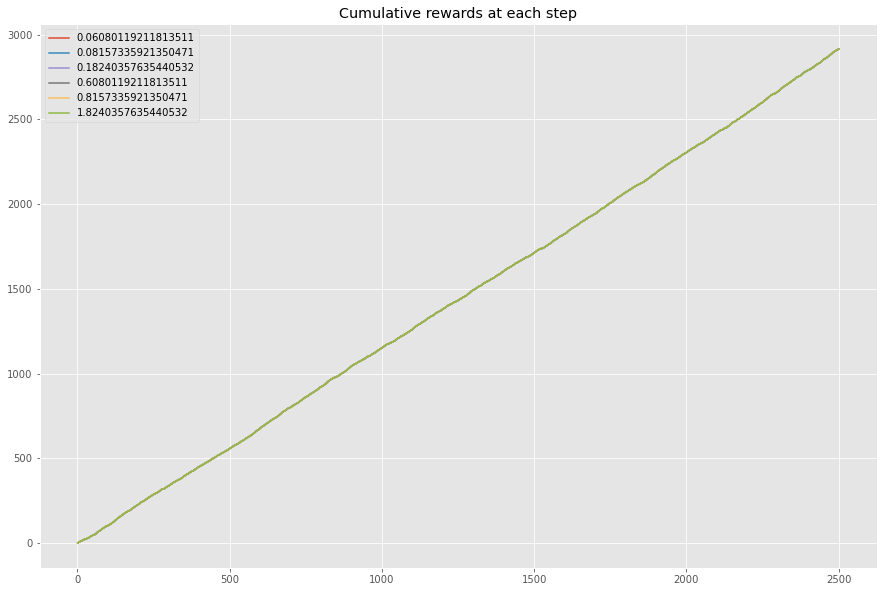

In [38]:
plt.style.use('ggplot')

# Plot the probability of choosing the best treatment
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)
for alpha in results_plot_linTS['alpha'].unique():
    results_linTS = results_plot_linTS[results_plot_linTS['alpha'] == alpha]
    ax.plot(results_linTS['n_step'], results_linTS['cumulative_rewards'], label = str(alpha))

plt.legend() 
plt.title("Cumulative rewards at each step")